## SOM 

The basic algorithm is fairly simple. For each training example:
1. Calculate the similarity between the input pattern and the weights arriving at each output node.
2. Find the most similar node; often referred to as the winner.
3. Select a set of output nodes which are located close to the winner in the output grid. This is called the neighbourhood.
4. Update the weights of all nodes in the neighbourhood such that their weights are moved closer to the input pattern.
<br> 
We will now go through these steps in somewhat more detail.


# 4.3 Data Clustering: Votes of MPs

The le votes.dat contains data about how all 349 members of the Swedish parliament did vote in the 31 rst votes during 20042005. There are also three additional les mpparty.dat, mpsex.dat and mpdistrict.dat with information about the party, gender and district of each member of parliament (MP). Finally, there is a le mpnames.txt with the names of the MPs. Your task is to use the SOM algorithm to position all MPs on a 10×10 grid according to their votes. By looking at where the dierent parties end up in the map you should be able to see if votes of the MPs actually reect the traditional leftright scale, and if there is a second dimension as well. You should be able to see which parties are far apart and which are close. By looking at the distribution of female and male MPs you could get some insight into whether MPs tend to vote dierently depending on their gender. You can also see if there is a tendency for MPs from dierent districts to vote systematically dierent. The le votes.dat denes a 349×31 matrix votes. Data are organised in row-by-row manner. Each one of 349 rows corresponds to a specic MP and each one of 31 columns to a specic vote. The elements are zero for a no-vote and one for a yes-vote. Missing votes (abstrained or non-present) are represented as 0.5. You should use the SOM algorithm to nd a topological mapping from the 31-dimensional input space to a 10×10 output grid. The network should be trained with each MPs votes as training data. If all works well, voting patterns that are similar will end up close to each other in the 10×10 map. Please display the results with respect to dierent attributes (i.e. party, gender, district) and describe the results, provide your interpretation.


In [30]:
import numpy as np
myarray = np.fromfile('./data_lab2/votes.dat', dtype=int)
myarray

array([741420080, 774908976, 741354549, ..., 741420081, 774908976,
       170929205])

In [9]:
349*31

10819

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mptchs
#import cPickle as pickle
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from multiprocessing import cpu_count, Process, Queue

In [ ]:
def man_dist_pbc(m, vector, shape=(10, 10)):
    """ Manhattan distance calculation of coordinates with periodic boundary condition
    :param m: {numpy.ndarray} array / matrix
    :param vector: {numpy.ndarray} array / vector
    :param shape: {tuple} shape of the SOM
    :return: {numpy.ndarray} Manhattan distance for v to m
    """
    dims = np.array(shape)
    delta = np.abs(m - vector)
    delta = np.where(delta > 0.5 * dims, np.abs(delta - dims), delta)
    return np.sum(delta, axis=len(m.shape) - 1)

In [14]:
x = np.arange(9.).reshape(3, 3)
np.where( x > 5, 5, 6 )


array([[6, 6, 6],
       [6, 6, 6],
       [5, 5, 5]])

In [13]:
x

array([[0., 1., 2.],
       [3., 4., 5.],
       [6., 7., 8.]])

In [23]:
x=10
y=10
indxmap = np.stack(np.unravel_index(np.arange(x * y, dtype=int).reshape(x, y), (x, y)), 2)
indxmap

array([[[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [0, 5],
        [0, 6],
        [0, 7],
        [0, 8],
        [0, 9]],

       [[1, 0],
        [1, 1],
        [1, 2],
        [1, 3],
        [1, 4],
        [1, 5],
        [1, 6],
        [1, 7],
        [1, 8],
        [1, 9]],

       [[2, 0],
        [2, 1],
        [2, 2],
        [2, 3],
        [2, 4],
        [2, 5],
        [2, 6],
        [2, 7],
        [2, 8],
        [2, 9]],

       [[3, 0],
        [3, 1],
        [3, 2],
        [3, 3],
        [3, 4],
        [3, 5],
        [3, 6],
        [3, 7],
        [3, 8],
        [3, 9]],

       [[4, 0],
        [4, 1],
        [4, 2],
        [4, 3],
        [4, 4],
        [4, 5],
        [4, 6],
        [4, 7],
        [4, 8],
        [4, 9]],

       [[5, 0],
        [5, 1],
        [5, 2],
        [5, 3],
        [5, 4],
        [5, 5],
        [5, 6],
        [5, 7],
        [5, 8],
        [5, 9]],

       [[6, 0],
        [6, 

In [167]:
from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot,
                   logical_and)
from collections import defaultdict, Counter
from warnings import warn

# for unit tests
from numpy.testing import assert_almost_equal, assert_array_almost_equal
from numpy.testing import assert_array_equal
import unittest

"""
    Minimalistic implementation of the Self Organizing Maps (SOM).
"""


def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.
    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))


def asymptotic_decay(learning_rate, t, max_iter):
    """Decay function of the learning process.
    Parameters
    ----------
    learning_rate : float
        current learning rate.
    t : int
        current iteration.
    max_iter : int
        maximum number of iterations for the training.
    """
    return learning_rate / (1+t/max_iter)

def exp_decay(learning_rate, t, max_iter, width, start_learning_rate=0.1): 
    """Decay function of the learning process. LIKE IN THE LECTURE
    Parameters
    ----------
    learning_rate : float
        current learning rate.
    t : int
        current iteration.
    max_iter : int
        maximum number of iterations for the training.
    width: int
        width of your grid in the output space 
    start_learning_rate: float
        
    """
    tau = max_iter/log(width/2)
    return start_learning_rate*exp(-t/tau)


class MiniSom(object):
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5,
                 decay_function=asymptotic_decay,
                 neighborhood_function='gaussian', random_seed=None):
        """Initializes a Self Organizing Maps.
        A rule of thumb to set the size of the grid for a dimensionality
        reduction task is that it should contain 5*sqrt(N) neurons
        where N is the number of samples in the dataset to analyze.
        E.g. if your dataset has 150 samples, 5*sqrt(150) = 61.23
        hence a map 8-by-8 should perform well.
        Here we have 349 samples and 5*sqrt(349) ~ 100 SO we go with a 10 by 10 grid!!
        Parameters
        ----------
        x : int
            x dimension of the SOM.
        y : int
            y dimension of the SOM.
        input_len : int
            Number of the elements of the vectors in input.
        sigma : float, optional (default=1.0)
            Spread of the neighborhood function, needs to be adequate
            to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T)
            where T is #num_iteration/2)
            learning_rate, initial learning rate
            (at the iteration t we have
            learning_rate(t) = learning_rate / (1 + t/T)
            where T is #num_iteration/2)
        decay_function : function (default=None)
            Function that reduces learning_rate and sigma at each iteration
            the default function is:
                        learning_rate / (1+t/max_iterarations)
            A custom decay function will need to to take in input
            three parameters in the following order:
            1. learning rate
            2. current iteration
            3. maximum number of iterations allowed
            Note that if a lambda function is used to define the decay
            MiniSom will not be pickable anymore.
        neighborhood_function : function, optional (default='gaussian')
            Function that weights the neighborhood of a position in the map
            possible values: 'gaussian', 'mexican_hat', 'bubble'
        random_seed : int, optional (default=None)
            Random seed to use.
        """
        if sigma >= x or sigma >= y:
            warn('Warning: sigma is too high for the dimension of the map.')

        self._random_generator = random.RandomState(random_seed)

        self._learning_rate = learning_rate
        self._sigma = sigma
        self._input_len = input_len
        # random initialization
        self._weights = self._random_generator.rand(x, y, input_len)*2-1

        for i in range(x):
            for j in range(y):
                # normalization
                norm = fast_norm(self._weights[i, j])
                self._weights[i, j] = self._weights[i, j] / norm

        self._activation_map = zeros((x, y))
        self._neigx = arange(x)
        self._neigy = arange(y)  # used to evaluate the neighborhood function
        self._decay_function = decay_function

        neig_functions = {'gaussian': self._gaussian,
                          'mexican_hat': self._mexican_hat,
                          'bubble': self._bubble,
                          'triangle': self._triangle}

        if neighborhood_function not in neig_functions:
            msg = '%s not supported. Functions available: %s'
            raise ValueError(msg % (neighborhood_function,
                                    ', '.join(neig_functions.keys())))

        if neighborhood_function in ['triangle',
                                     'bubble'] and divmod(sigma, 1)[1] != 0:
            warn('sigma should be an integer when triangle or bubble' +
                 'are used as neighborhood function')

        self.neighborhood = neig_functions[neighborhood_function]

    def get_weights(self):
        """Returns the weights of the neural network"""
        return self._weights

    def _activate(self, x):
        """Updates matrix activation_map, in this matrix
           the element i,j is the response of the neuron i,j to x"""
        s = subtract(x, self._weights)  # x - w
        it = nditer(self._activation_map, flags=['multi_index'])
        while not it.finished:
            # || x - w ||
            self._activation_map[it.multi_index] = fast_norm(s[it.multi_index])
            it.iternext()

    def activate(self, x):
        """Returns the activation map to x"""
        self._activate(x)
        return self._activation_map

    def _gaussian(self, c, sigma):
        """Returns a Gaussian centered in c"""
        d = 2*pi*sigma*sigma
        ax = exp(-power(self._neigx-c[0], 2)/d)
        ay = exp(-power(self._neigy-c[1], 2)/d)
        return outer(ax, ay)  # the external product gives a matrix

    def _mexican_hat(self, c, sigma):
        """Mexican hat centered in c"""
        xx, yy = meshgrid(self._neigx, self._neigy)
        p = power(xx-c[0], 2) + power(yy-c[1], 2)
        d = 2*pi*sigma*sigma
        return exp(-p/d)*(1-2/d*p)

    def _bubble(self, c, sigma):
        """Constant function centered in c with spread sigma.
           sigma should be an odd value,
        """
        ax = logical_and(self._neigx > c[0]-sigma,
                         self._neigx < c[0]+sigma)
        ay = logical_and(self._neigy > c[1]-sigma,
                         self._neigy < c[1]+sigma)
        return outer(ax, ay)*1.

    def _triangle(self, c, sigma):
        """Triangular function centered in c with spread sigma."""
        triangle_x = (-abs(c[0] - self._neigx)) + sigma
        triangle_y = (-abs(c[1] - self._neigy)) + sigma
        triangle_x[triangle_x < 0] = 0.
        triangle_y[triangle_y < 0] = 0.
        return outer(triangle_x, triangle_y)

    def _check_iteration_number(self, num_iteration):
        if num_iteration < 1:
            raise ValueError('num_iteration must be > 1')

    def _check_input_len(self, data):
        """Checks that the data in input is of the correct shape."""
        data_len = len(data[0])
        if self._input_len != data_len:
            msg = 'Received %d features, expected %d.' % (data_len,
                                                          self._input_len)
            raise ValueError(msg)

    def winner(self, x):
        """Computes the coordinates of the winning neuron for the sample x"""
        self._activate(x)
        return unravel_index(self._activation_map.argmin(),
                             self._activation_map.shape)

    def update(self, x, win, t):
        """Updates the weights of the neurons.
        Parameters
        ----------
        x : np.array
            Current pattern to learn
        win : tuple
            Position of the winning neuron for x (array or tuple).
        t : int
            Iteration index
        """
        eta = self._decay_function(self._learning_rate, t, self.T)
        # sigma and learning rate decrease with the same rule
        sig = self._decay_function(self._sigma, t, self.T)
        # improves the performances
        g = self.neighborhood(win, sig)*eta
        it = nditer(g, flags=['multi_index'])

        while not it.finished:
            # eta * neighborhood_function * (x-w)
            x_w = (x - self._weights[it.multi_index])
            self._weights[it.multi_index] += g[it.multi_index] * x_w
            # normalization
            norm = fast_norm(self._weights[it.multi_index])
            self._weights[it.multi_index] = self._weights[it.multi_index]/norm
            it.iternext()

    def quantization(self, data):
        """Assigns a code book (weights vector of the winning neuron)
        to each sample in data."""
        self._check_input_len(data)
        q = zeros(data.shape)
        for i, x in enumerate(data):
            q[i] = self._weights[self.winner(x)]
        return q

    def random_weights_init(self, data):
        """Initializes the weights of the SOM
        picking random samples from data"""
        self._check_input_len(data)
        it = nditer(self._activation_map, flags=['multi_index'])
        while not it.finished:
            rand_i = self._random_generator.randint(len(data))
            self._weights[it.multi_index] = data[rand_i]
            norm = fast_norm(self._weights[it.multi_index])
            self._weights[it.multi_index] = self._weights[it.multi_index]/norm
            it.iternext()

    def train_random(self, data, num_iteration):
        """Trains the SOM picking samples at random from data"""
        self._check_iteration_number(num_iteration)
        self._check_input_len(data)
        self._init_T(num_iteration)

        for iteration in range(num_iteration):
            # pick a random sample
            rand_i = self._random_generator.randint(len(data))
            self.update(data[rand_i], self.winner(data[rand_i]), iteration)

    def train_batch(self, data, num_iteration):
        """Trains using all the vectors in data sequentially"""
        self._check_iteration_number(num_iteration)
        self._check_input_len(data)
        self._init_T(len(data)*num_iteration)
        iteration = 0

        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx], self.winner(data[idx]), iteration)
            iteration += 1

    def _init_T(self, num_iteration):
        """Initializes the parameter T needed to adjust the learning rate"""
        # keeps the learning rate nearly constant
        # for the last half of the iterations
        self.T = num_iteration/2

    def distance_map(self):
        """Returns the distance map of the weights.
        Each cell is the normalised sum of the distances between
        a neuron and its neighbours."""
        um = zeros((self._weights.shape[0], self._weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if (ii >= 0 and ii < self._weights.shape[0] and
                            jj >= 0 and jj < self._weights.shape[1]):
                        w_1 = self._weights[ii, jj, :]
                        w_2 = self._weights[it.multi_index]
                        um[it.multi_index] += fast_norm(w_1-w_2)
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self, data):
        """
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        self._check_input_len(data)
        a = zeros((self._weights.shape[0], self._weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self, data):
        """Returns the quantization error computed as the average
        distance between each input sample and its best matching unit."""
        self._check_input_len(data)
        error = 0
        for x in data:
            error += fast_norm(x-self._weights[self.winner(x)])
        return error/len(data)

    def win_map(self, data):
        """Returns a dictionary wm where wm[(i,j)] is a list
        with all the patterns that have been mapped in the position i,j."""
        self._check_input_len(data)
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap

    def labels_map(self, data, labels):
        """Returns a dictionary wm where wm[(i,j)] is a dictionary
        that contains the number of samples from a given label
        that have been mapped in position i,j.
        Parameters
        ----------
        data : data matrix
        label : list or array that contains the label of each sample in data.
        """
        self._check_input_len(data)
        winmap = defaultdict(list)
        for x, l in zip(data, labels):
            winmap[self.winner(x)].append(l)
        for position in winmap:
            winmap[position] = Counter(winmap[position])
        return winmap

In [190]:
FILE_ADR = './data_lab2/votes.dat'
def load_data(file_adr=FILE_ADR): 
    """
    Load data from votes.dat file and gives back a 349*31 array corresponding
    to the 31 votes of each MP 
    :return: array WHERE zero for a no-vote and one for a yes-vote. Missing votes 
    (abstrained or non-present) are represented as 0.5.
    """
    f = open(FILE_ADR)
    l = f.read()
    l = l.split(',')
    ## To avoid \n 
    l[-1] = '0'
    array_MP_votes = np.array(l)

    array_MP_votes = array_MP_votes.astype(float)

    array_MP_votes = array_MP_votes.reshape(349,31)
    return( array_MP_votes )
array_MP_votes = load_data()
array_MP_votes

array([[0. , 1. , 0. , ..., 0.5, 0. , 1. ],
       [0. , 1. , 1. , ..., 0. , 0.5, 0. ],
       [0. , 1. , 0. , ..., 0.5, 0. , 1. ],
       ...,
       [1. , 1. , 1. , ..., 1. , 1. , 0.5],
       [0. , 1. , 0. , ..., 0.5, 0.5, 0.5],
       [0. , 1. , 1. , ..., 0. , 0.5, 0. ]])

In [184]:
float(1)

1.0

### I do not think we need to normalize data here!! 
array_test = array_MP_votes
array_test = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, array_test)
array_test
del array_test

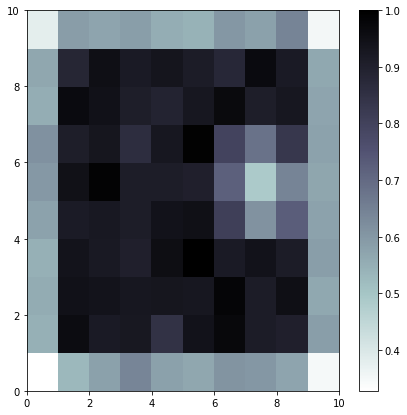

In [98]:
som = MiniSom(10, 10, 31, sigma=0.3, learning_rate=0.5) # initialization of 10x10 SOM
som.train_random(array_MP_votes, 100)

plt.figure(figsize=(7, 7))
# Plotting the response for each pattern in the iris dataset
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()
plt.show()

In [145]:
## Retrieve party target from mpparty.dat
"""
LEGEND
0=no party, 1='m', 2='fp', 3='s', 4='v', 5='mp', 6='kd', 7='c'
"""
FILE_ADR_PARTY = './data_lab2/mpparty.dat'
f = open(FILE_ADR_PARTY)
l = f.read()
l = l.split('\n\t')
l[0]='1'
list_MP_party = [int(x) for x in l]
list_MP_party = np.array(list_MP_party)
sum(list_MP_party==3)



144

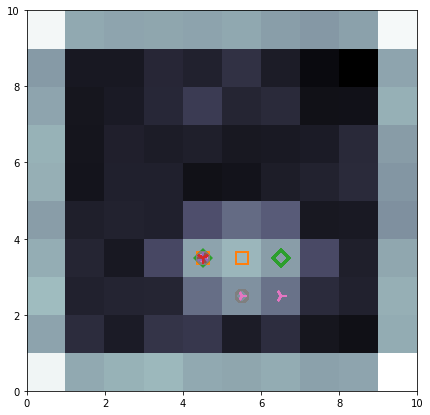

In [125]:
som = MiniSom(10, 10, 31, sigma=0.3, learning_rate=0.5) # initialization of 10x10 SOM
som.train_random(array_MP_votes, 100)

plt.figure(figsize=(7, 7))
# Plotting the response for each pattern in the iris dataset
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
#plt.colorbar()



## use different colors and markers for each label
markers = ['o', 's', 'D','1', '2', '3','4','8']
colors = ['C0', 'C1', 'C2','C3', 'C4', 'C5','C6', 'C7']


for cnt, xx in enumerate(array_MP_votes):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[list_MP_party[cnt]], markerfacecolor='None',
             markeredgecolor=colors[list_MP_party[cnt]], markersize=12, markeredgewidth=2)
plt.axis([0, 10, 0, 10])
plt.show()

In [119]:
data[0] == array_MP_votes[0]

C:\Users\Mous\Programmes\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

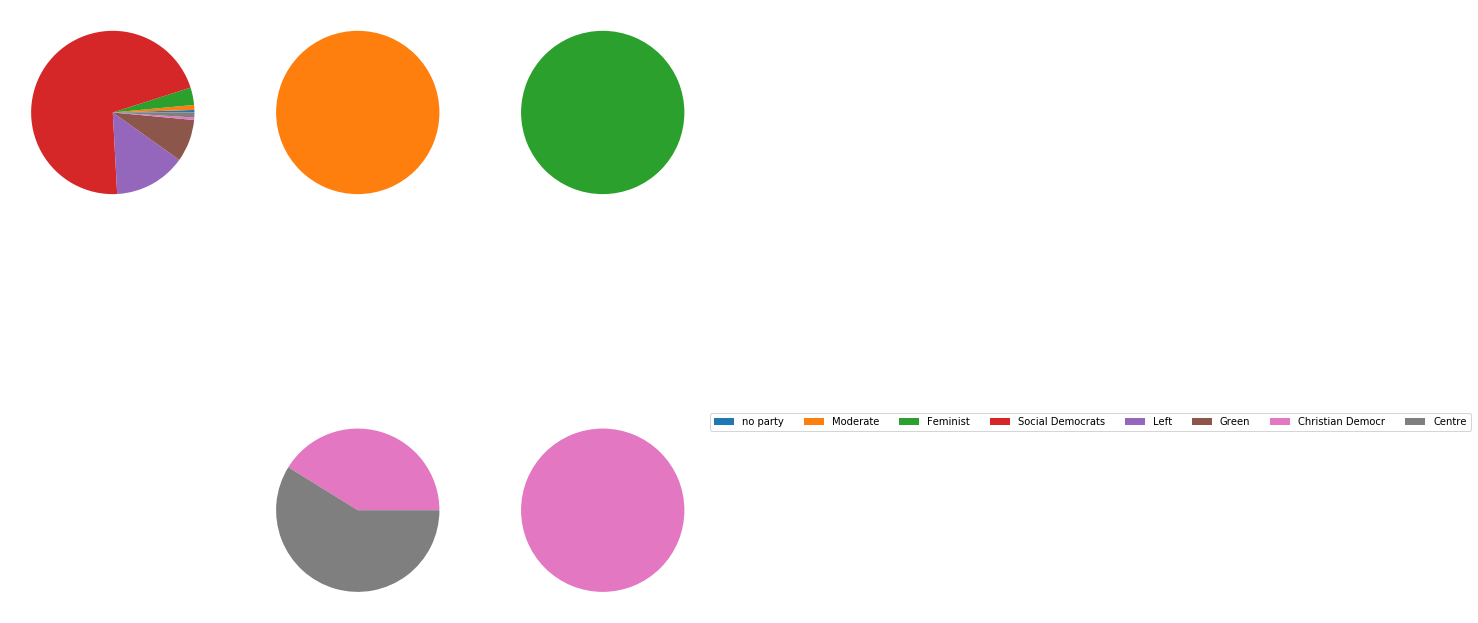

In [143]:
from matplotlib.gridspec import GridSpec

label = list_MP_party
labels_map = som.labels_map(array_MP_votes, label)
label_names = np.unique(label)
label_names_legend = ['no party', 'Moderate', 'Feminist', 'Social Democrats','Left', 'Green', 'Christian Democr', 'Centre']

plt.figure(figsize=(30, 50))
the_grid = GridSpec(7, 7)
for position in labels_map.keys():
    
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[6-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
plt.legend(patches, label_names_legend, bbox_to_anchor=(1, 1), ncol=8)
plt.show()

## Comments: 

In red we have the social democrats corresponding to the Left and in purple we have the Christian Democrats basically corresponding to the right. We note that this grid reflects quite well the discrepancies between both parties and they are on the opposite side. I still had to check on the net to know more about those two parties. Concerning Social democrats, first they are the most represented in our dataset as it is the case in real life as they have 89,010 members in total. Second, according to Wikipedia: "social democracy is a political, social and economic ideology that supports economic and social interventions to promote social justice within the framework of a liberal democratic polity and capitalist economy.". So we are dealing with the left. On the other hand, " Christian democratic parties are moderately conservative and centre-right overall". It would seem that they do not agree so often with Social Democrats according to our results. 


Christian democrats and Centre seem to converge on various matters. Without any prior knowledge on politics in Sweden I had to double check in order to know wheter this result makes sense or not. According to Wikipedia: " first entered parliament in 1985, through electoral cooperation with the Centre Party" and its International affiliation is Centrist Democrat International. Consequently this result makes sense indeed. 

Feminists and Moderate parties are separate from the other parties globally. This might suppose they have different views globally on the matters discussed in parliament (maybe they do not vote). 


In [127]:
label = list_MP_party
label_names = np.unique(label)
label_names


array([0, 1, 2, 3, 4, 5, 6, 7])

In [140]:
labels_map

defaultdict(list,
            {(5, 3): Counter({1: 53}),
             (6, 3): Counter({2: 41}),
             (4,
              3): Counter({3: 144,
                      4: 29,
                      5: 17,
                      2: 7,
                      0: 1,
                      1: 2,
                      6: 1,
                      7: 2}),
             (5, 2): Counter({6: 14, 7: 20}),
             (6, 2): Counter({6: 18})})

In [151]:
## Retrieve party gender from mppsex.dat
"""
LEGEND
Male 0, Female 1
"""
FILE_ADR_PARTY = './data_lab2/mpsex.dat'
file_gender = open(FILE_ADR_PARTY)
l_gender = file_gender.read()
l_gender= l_gender.split('\n\t')
l_gender=l_gender[1:] 
l_gender = [int(i) for i in l_gender]
l_gender = np.array(l_gender)




[0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,


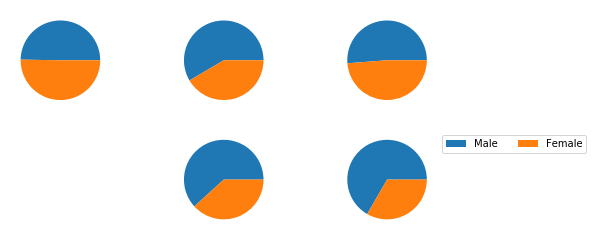

In [154]:
label_gender = l_gender
labels_map = som.labels_map(array_MP_votes, label_gender)
label_gender_names = np.unique(label_gender)
label_gender_names_legend = ['Male', 'Female']

plt.figure(figsize=(20, 15))
the_grid = GridSpec(7, 7)
for position in labels_map.keys():
    
    label_fracs = [labels_map[position][l] for l in label_gender_names]
    plt.subplot(the_grid[6-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
plt.legend(patches, label_gender_names_legend, bbox_to_anchor=(1, 1), ncol=2)
plt.show()

## Comments 
According to Wkipedia, women in Sweden are 45% of the political representatives in the Swedish Parliament. We see that we have a quite balanced data and gender does not really influence decisions. I cannot find any information on gender repartition within parties in Sweden. So I will check for the Feminist party for example how balanced is the set. /


In [161]:
label_gender
list_MP_party
list_party_gender = list(zip(label_gender,list_MP_party))
list_feminists_gender = [couple for couple in list_party_gender if couple[1]==2]
count_male, count_female = 0, 0 
for couple in list_feminists_gender:
    if couple[0]==0:
        count_male+=1
    else:
        count_female+=1

print(count_male, count_female)

25 23


## Comments 
There are 25 males and 23 females. There as much men as women within the Feminist Party which can be surprising. 

In [164]:
## Retrieve party district from mppdistrict.dat
"""
LEGEND
Districts goes from 1 to 29
"""
FILE_ADR_DISTRICT = './data_lab2/mpdistrict.dat'
file_district = open(FILE_ADR_DISTRICT)
l_district = file_district.read()
l_district= l_district.split('\n\t')
l_district  = [int(i) for i in l_district ]
l_district = np.array(l_district)




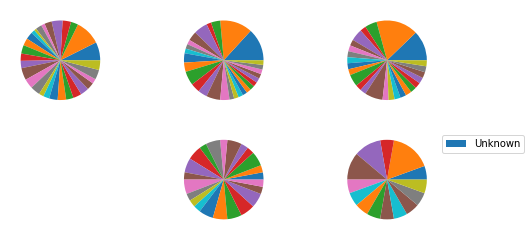

In [165]:
label_districts = l_district
labels_map = som.labels_map(array_MP_votes, label_districts)
label_district_names = np.unique(label_districts)
label_gender_names_legend = ['Unknown']

plt.figure(figsize=(20, 15))
the_grid = GridSpec(7, 7)
for position in labels_map.keys():
    
    label_fracs = [labels_map[position][l] for l in label_district_names]
    plt.subplot(the_grid[6-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
plt.legend(patches, label_gender_names_legend, bbox_to_anchor=(1, 1), ncol=1)
plt.show()

## Comments 
We note that there is predominant district colored in orange supra. However globally the decision making do no seem to be linked to the district provenance. What we can say is that within the Feminist Party there are two predominant districts (orange and blue) and this very orange district is also predominant within the Christian Democrats Party. We could not say more a priori as the repartition of the districts is quite uniform. 

## 4.1 Topological Ordering of Animal Species
The SOM algorithm can be used to assign a natural order to objects characterized only by a large number of attributes. This is done by letting the SOM algorithm create a topological mapping from the high-dimensional attribute space to a one-dimensional output space. As sample data, please use a simple database of 32 animal species where each animal is characterized by 84 binary attributes. The data is in the le animals.dat. This le denes the 32×84 matrix props where each row contains the attributes of one animal. The data are organised in row-by-row manner. There is also a le animalnames.dat with the names of the animals in the same order. This vector should only be used to print out the nal ordering in a more readable format. These 84 values serve as input and 100 nodes arranged in a one-dimensional topology, i.e. in a linear sequence, constitute the output. Train the SOM network by showing the attribute vector of one animal at a time. The SOM algorithm should now be able to create a mapping onto the 100 output nodes such that similar animals tend to be close while dierent animals tend to be further away along the sequence of nodes. In order to get this onedimensional topology, the network has to be trained using a one-dimensional neighbourhood. In particular, your task is to write the core algorithm. Use a weight matrix of size 100×84 initialized with random numbers between zero and one. Use an
9
outer loop to train the network for about 20 epochs, and an inner loop which loops through the 32 animals, one at a time. For each animal you will have to pick out the corresponding row from the props matrix. Then nd the row of the weight matrix with the shortest distance to this attribute vector (p). Note that you cannot use a scalar product since the attribute vectors are not normalized. Therefore you have to take the dierence between the two vectors and calculate the length of this dierence vector. Once you have the index to the winning node, it is time to update the weights. Update the weights so that they come a bit closer to the input pattern. A suitable step size is 0.2. Note that only weights to the winning node and its neighbours should be updated. The neighbours are in this case the nodes with an index close to that of the winning one. You should start with a large neighbourhood and gradually make it smaller. Make the size of the neighbourhood depend on the epoch loop variable so that you start with a neighbourhood of about 50 and end up close to one or zero. Finally, you have to print out the result, i.e. the animals in a natural order. Do this by looping through all animals once more, again calculating the index of the winning output node. Save these indices in a 32 element vector pos. By sorting this vector we will get the animals in the desired order. Check the resulting order. Does it make sense? If everything works, animals next to each other in the listing should always have some similarity between them. Insects should typically be grouped together, separate from the dierent cats, for example.


## Processing the data 


In [195]:
FILE_ADR_ANIMALS = './data_lab2/animals.dat'
def load_data_bis(n_row, n_col, file_adr=FILE_ADR_ANIMALS): 
    """
    Load data from votes.dat file and gives back a n_row*n_col array corresponding
    to the data
    :return: array WHERE attributes are binary values
    """
    f = open(file_adr)
    l = f.read()
    l = l.split(',')
    ## To avoid \n 
    l[-1] = '0'
    array_animals_attr = np.array(l)

    array_animals_attr = array_animals_attr.astype(float)

    array_animals_attr = array_animals_attr.reshape(n_row, n_col)
    return( array_animals_attr )
array_animals_attr = load_data_bis(32, 84)
array_animals_attr

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 4.2 Cyclic Tour


In the previous example, the SOM algorithm in eect positioned a one-dimensional curve in the 84-dimensional input space so that it passed close to the places where the training examples were located. Now the same technique can be used to layout a curve in a two-dimensional plane so that it passes a set of points. In fact, this can be interpreted as a variant of the travelling salesman problem. The training points correspond to the cities and the curve corresponds to the tour. SOM algorithm should be able to nd a fairly short route which passes all cities. The actual algorithm is very similar to what you implemented in the previons task. In fact, you might be able to reuse much of the code. The main dierences are: • The input space has two dimensions instead of 84. The output grid should have 10 nodes, corresponding to the ten cities used in this example. • The neighbourhood should be circular since we are looking for a circular tour. When calculating the neighbours you have to make sure that the rst and the last output node are treated as next neighbours. • The size of the neighbourhood must be smaller, corresponding to the smaller number of output nodes. It is reasonable to start with a neighbourhood size of 2 and then change it to 1 and nally zero. • When presenting the result, it is better to plot the suggested tour graphically than to sort the cities. The location of the ten cities is dened in the le cities.dat which denes the 10×2 matrix city. Each row contains the coordinates of one city (value between zero and one).
10

Please plot both the tour and the training points. Give your interpretation.